# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Compute the $Q_0$

## Configuration

### Load libraries and setup

In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output

In [2]:
from mltier1 import Field, Q_0, parallel_process

In [3]:
%load_ext autoreload

In [4]:
%autoreload

In [5]:
from IPython.display import clear_output

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Area limits

In [7]:
# Busy week Hatfield 2017
ra_down = 170.
ra_up = 190.
dec_down = 46.8
dec_up = 55.9

In [8]:
field = Field(170.0, 190.0, 46.8, 55.9)

## Load data

In [9]:
combined = Table.read("pw.fits")

In [10]:
lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.1.fits")

In [11]:
np.array(combined.colnames)

array(['AllWISE', 'objID', 'ra', 'dec', 'raErr', 'decErr', 'W1mag',
       'W1magErr', 'i', 'iErr'], 
      dtype='<U8')

In [12]:
np.array(lofar_all.colnames)

array(['Source_id', 'RA', 'E_RA', 'E_RA_tot', 'DEC', 'E_DEC', 'E_DEC_tot',
       'Peak_flux', 'E_Peak_flux', 'E_Peak_flux_tot', 'Total_flux',
       'E_Total_flux', 'E_Total_flux_tot', 'Maj', 'E_Maj', 'Min', 'E_Min',
       'PA', 'E_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID'], 
      dtype='<U16')

### Filter catalogues

In [13]:
lofar = field.filter_catalogue(lofar_all, colnames=("RA", "DEC"))

### Sky coordinates

In [14]:
coords_combined = SkyCoord(combined['ra'], 
                           combined['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [15]:
coords_lofar = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

### Summary of galaxy types in the combined catalogue

In [16]:
combined_matched = (~np.isnan(combined["i"]) & 
                    ~np.isnan(combined["W1mag"]))
np.sum(combined_matched) # Matches

1339600

In [17]:
combined_panstarrs = (~np.isnan(combined["i"]) & 
                      np.isnan(combined["W1mag"]))
np.sum(combined_panstarrs) # Only PanSTARSS

3071319

In [18]:
combined_wise =(np.isnan(combined["i"]) & 
                ~np.isnan(combined["W1mag"]))
np.sum(combined_wise) # Only WISE

821044

In [19]:
combined_i = combined_matched | combined_panstarrs
combined_w1 = combined_matched | combined_wise

## $Q_0$ dependence on the radius

We will iterate 10 times for each radius. However, the error is so small that a direct computation can be accurate to 4 significant figures.

In [20]:
n_iter = 10

In [21]:
rads = list(range(1,26))

### i-band

In [22]:
q_0_comp_i = Q_0(coords_lofar, coords_combined[combined_i], field)

In [23]:
q_0_rad_i = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_i(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_i.append(np.mean(q_0_rad_aux))
    print("{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(radius, 
            np.mean(q_0_rad_aux), np.std(q_0_rad_aux), 
            np.min(q_0_rad_aux), np.max(q_0_rad_aux)))

 1 0.36572 +/- 0.00018 [0.36553 0.36603]
 2 0.45812 +/- 0.00025 [0.45774 0.45846]
 3 0.48456 +/- 0.00036 [0.48400 0.48525]
 4 0.49854 +/- 0.00053 [0.49757 0.49936]
 5 0.50720 +/- 0.00026 [0.50670 0.50769]
 6 0.51288 +/- 0.00061 [0.51165 0.51366]
 7 0.51704 +/- 0.00085 [0.51567 0.51855]
 8 0.52121 +/- 0.00117 [0.51903 0.52260]
 9 0.52557 +/- 0.00115 [0.52404 0.52787]
10 0.52924 +/- 0.00090 [0.52758 0.53052]
11 0.53153 +/- 0.00153 [0.52944 0.53416]
12 0.53353 +/- 0.00172 [0.52995 0.53597]
13 0.53425 +/- 0.00157 [0.53222 0.53666]
14 0.53978 +/- 0.00130 [0.53762 0.54276]
15 0.54293 +/- 0.00215 [0.54034 0.54767]
16 0.54151 +/- 0.00142 [0.53815 0.54344]
17 0.54295 +/- 0.00252 [0.53920 0.54699]
18 0.54721 +/- 0.00205 [0.54411 0.55094]
19 0.54764 +/- 0.00242 [0.54378 0.55104]
20 0.55034 +/- 0.00400 [0.54354 0.55672]
21 0.55766 +/- 0.00485 [0.55296 0.56708]
22 0.55652 +/- 0.00538 [0.54563 0.56334]
23 0.56157 +/- 0.00516 [0.55519 0.57072]
24 0.56506 +/- 0.00532 [0.55730 0.57526]
25 0.56585 +/- 0

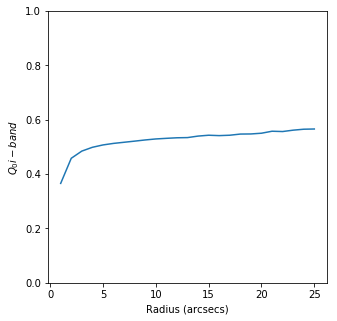

In [24]:
plt.rcParams["figure.figsize"] = (5,5)
plot(rads, q_0_rad_i)
xlabel("Radius (arcsecs)")
ylabel("$Q_0 i-band$")
ylim([0, 1]);

### W1-band

In [25]:
q_0_comp_w1 = Q_0(coords_lofar, coords_combined[combined_w1], field)

In [26]:
q_0_rad_w1 = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w1(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w1.append(np.mean(q_0_rad_aux))
    print("{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(radius, 
            np.mean(q_0_rad_aux), np.std(q_0_rad_aux), 
            np.min(q_0_rad_aux), np.max(q_0_rad_aux)))

 1 0.44979 +/- 0.00015 [0.44965 0.45007]
 2 0.59763 +/- 0.00011 [0.59748 0.59786]
 3 0.64805 +/- 0.00028 [0.64752 0.64837]
 4 0.67413 +/- 0.00023 [0.67376 0.67450]
 5 0.69133 +/- 0.00017 [0.69100 0.69168]
 6 0.70524 +/- 0.00038 [0.70453 0.70579]
 7 0.71822 +/- 0.00039 [0.71752 0.71894]
 8 0.73079 +/- 0.00049 [0.73019 0.73155]
 9 0.74399 +/- 0.00044 [0.74339 0.74496]
10 0.75385 +/- 0.00054 [0.75307 0.75465]
11 0.76156 +/- 0.00064 [0.76033 0.76267]
12 0.76546 +/- 0.00079 [0.76447 0.76665]
13 0.76854 +/- 0.00071 [0.76700 0.76941]
14 0.77319 +/- 0.00061 [0.77243 0.77446]
15 0.77505 +/- 0.00083 [0.77360 0.77628]
16 0.77629 +/- 0.00075 [0.77518 0.77771]
17 0.77584 +/- 0.00088 [0.77418 0.77767]
18 0.77580 +/- 0.00141 [0.77293 0.77800]
19 0.77508 +/- 0.00098 [0.77308 0.77671]
20 0.77446 +/- 0.00192 [0.77165 0.77745]
21 0.77354 +/- 0.00164 [0.77087 0.77599]
22 0.77034 +/- 0.00119 [0.76876 0.77308]
23 0.76760 +/- 0.00216 [0.76286 0.77033]
24 0.76595 +/- 0.00144 [0.76254 0.76802]
25 0.75866 +/- 0

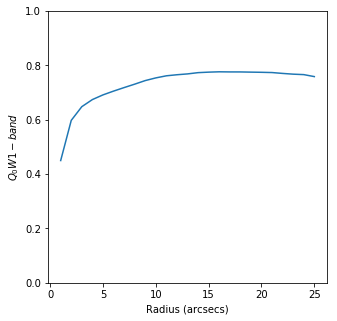

In [27]:
plt.rcParams["figure.figsize"] = (5,5)
plot(rads, q_0_rad_w1)
xlabel("Radius (arcsecs)")
ylabel("$Q_0 W1-band$")
ylim([0, 1]);